In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import metrics 
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from keras.layers import Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D

import seaborn as sns
import matplotlib.pyplot as plt

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import random

In [2]:
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

In [3]:
data = "../input/seaanimals"

In [4]:
 image_dir = Path(data)

# # Get filepaths and labels
# filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

# labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# filepaths = pd.Series(filepaths, name='Filepath').astype(str)
# labels = pd.Series(labels, name='Label')

# # Concatenate filepaths and labels
# image_df = pd.concat([filepaths, labels], axis=1)


# Load filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Limit the number of images for each class to 498
image_df = image_df.groupby('Label').apply(lambda x: x.sample(n=min(498, len(x)))).reset_index(drop=True)

In [5]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("../input/sea-animals-image-dataste").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [6]:
image_df

,Filepath,Label
0,../input/seaanimals/Corals/4391260135_0fe6997a...,Corals
1,../input/seaanimals/Corals/25468225161_762020d...,Corals
2,../input/seaanimals/Corals/14059290420_7d15b78...,Corals
3,../input/seaanimals/Corals/5569948669_e81021e2...,Corals
4,../input/seaanimals/Corals/6217351263_c7124aa8...,Corals
...,...,...
2982,../input/seaanimals/Lobster/14013316296_0c7662...,Lobster
2983,../input/seaanimals/Lobster/4772306556_736c0e8...,Lobster
2984,../input/seaanimals/Lobster/339437585_18cea39e...,Lobster
2985,../input/seaanimals/Lobster/35689212722_9cbd50...,Lobster


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3
)

In [8]:
train_generator = train_datagen.flow_from_directory(
    data,
    target_size=(200, 200),
    batch_size=20,
    shuffle = True,
    seed =22224,
    class_mode='categorical',
#     color_mode='grayscale',
    subset='training'
)

Found 2538 images belonging to 6 classes.


In [9]:
validation_generator = train_datagen.flow_from_directory(
    data,
    target_size=(200, 200),
    batch_size=20,
    shuffle = True,
    seed =22224,
    class_mode='categorical',
#     color_mode='grayscale',
    subset='validation'
)

Found 1084 images belonging to 6 classes.


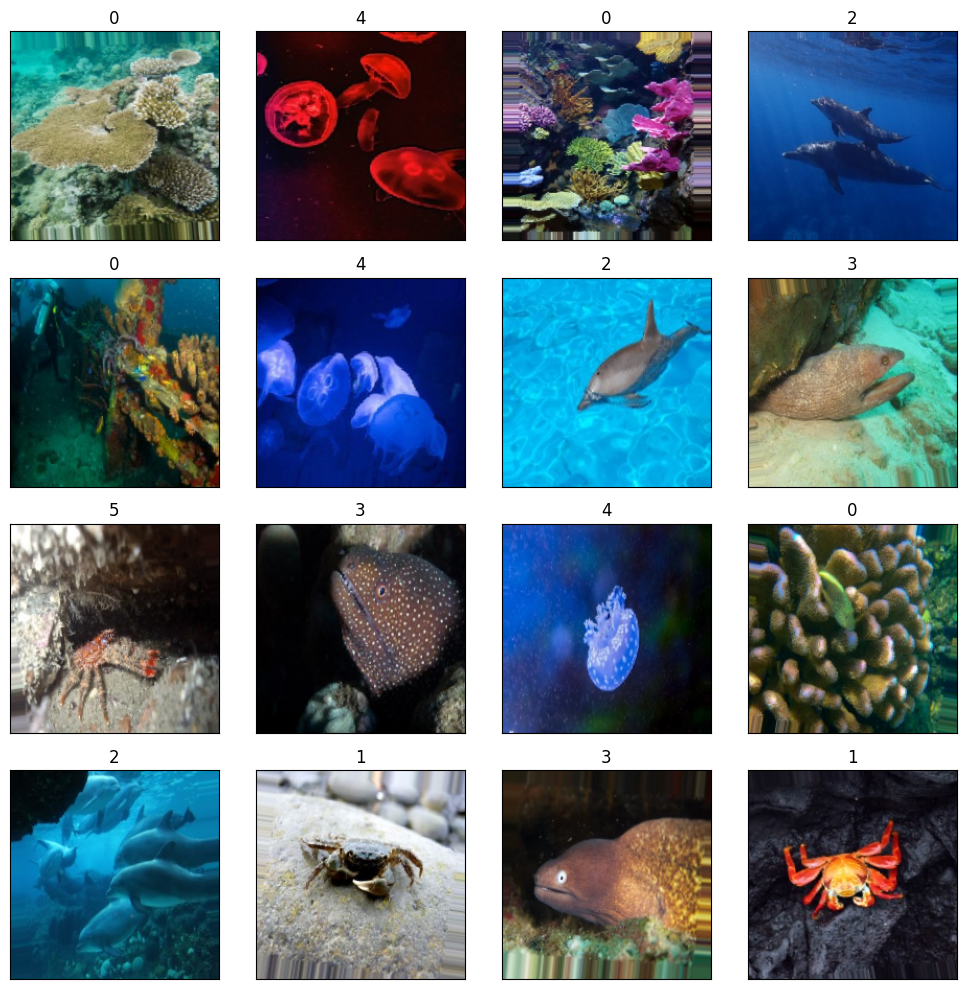

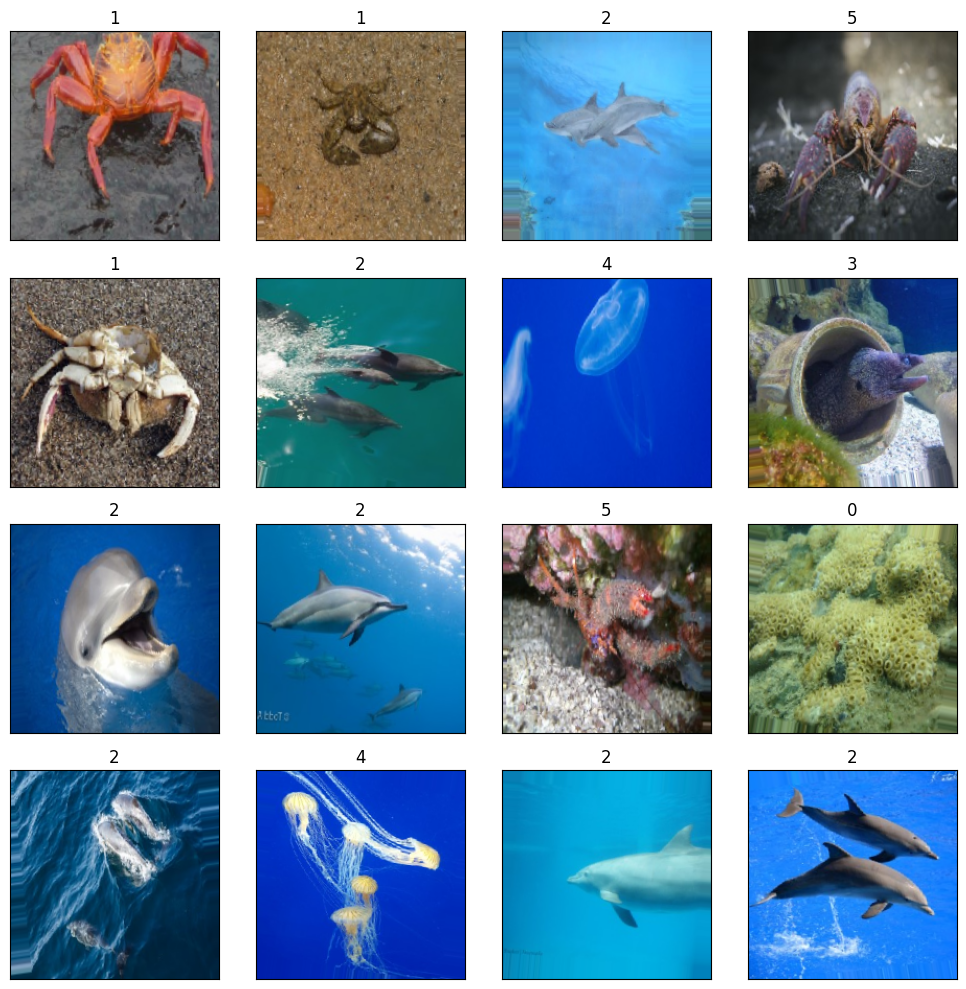

In [10]:


# Plot random images from the training set
random_train_index = np.random.randint(0, len(train_generator), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    batch = next(train_generator)
    img = batch[0][0]
    label = batch[1][0]
    ax.imshow(img)
    ax.set_title(label.argmax())  # assuming labels are one-hot encoded
plt.tight_layout()
plt.show()

# Plot random images from the validation set
random_validation_index = np.random.randint(0, len(validation_generator), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    batch = next(validation_generator)
    img = batch[0][0]
    label = batch[1][0]
    ax.imshow(img)
    ax.set_title(label.argmax())  
plt.tight_layout()
plt.show()

In [11]:

model = Sequential()


model.add(Conv2D(6, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy' , metrics.Precision(), metrics.Recall()])


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 198, 198, 6)       24        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 196, 196, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 196, 196, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 98, 98, 16)        0         
 D)                                                              
                                                        

In [13]:
early_stop=EarlyStopping(monitor='val_loss',patience=20, min_delta=0.002)

In [14]:
# history = model.fit(train_images,
#     steps_per_epoch=len(train_images),
#     validation_data=validation_images,
#     validation_steps=len(validation_images),
#     epochs=50)

history = model.fit(train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=60,
    callbacks=[early_stop])

Epoch 1/60


2024-01-07 22:56:53.707666: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


127/127 [==============================] - 51s 348ms/step - loss: 1.4987 - accuracy: 0.4704 - precision: 0.5760 - recall: 0.3597 - val_loss: 2.7285 - val_accuracy: 0.2159 - val_precision: 0.2159 - val_recall: 0.2159
Epoch 2/60
127/127 [==============================] - 35s 277ms/step - loss: 1.2308 - accuracy: 0.5611 - precision: 0.6849 - recall: 0.4283 - val_loss: 1.8543 - val_accuracy: 0.3026 - val_precision: 0.3147 - val_recall: 0.2860
Epoch 3/60
127/127 [==============================] - 35s 275ms/step - loss: 1.1551 - accuracy: 0.5745 - precision: 0.7015 - recall: 0.4500 - val_loss: 1.3465 - val_accuracy: 0.5323 - val_precision: 0.6466 - val_recall: 0.4659
Epoch 4/60
127/127 [==============================] - 35s 275ms/step - loss: 1.0703 - accuracy: 0.6095 - precision: 0.7249 - recall: 0.4744 - val_loss: 0.9314 - val_accuracy: 0.6614 - val_precision: 0.8086 - val_recall: 0.5185
Epoch 5/60
127/127 [==============================] - 35s 275ms/step - loss: 1.0364 - accuracy: 0.6241 

In [15]:
results = model.evaluate(validation_generator)

55/55 [==============================] - 11s 195ms/step - loss: 0.6307 - accuracy: 0.7555 - precision: 0.8118 - recall: 0.7002


In [16]:
print("Accuracy:", results[1])
print("Precision:", results[2])
print("Recall (Sensitivity):", results[3])

Accuracy: 0.7555350661277771
Precision: 0.8117647171020508
Recall (Sensitivity): 0.7001845240592957


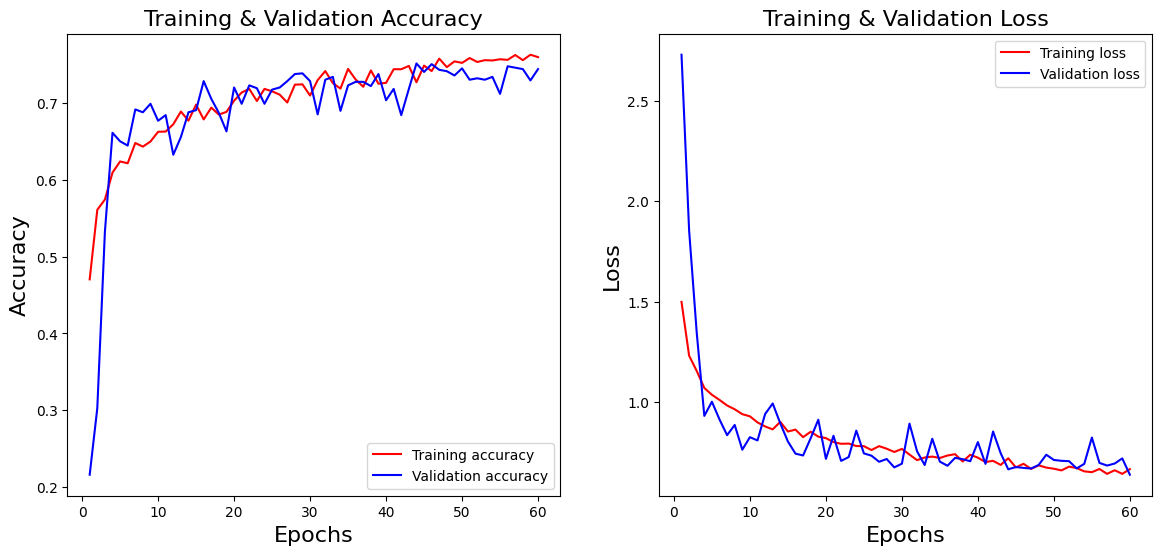

In [17]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))


# Plot the model accuracy vs Epochs
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()


# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend();

55/55 [==============================] - 11s 187ms/step


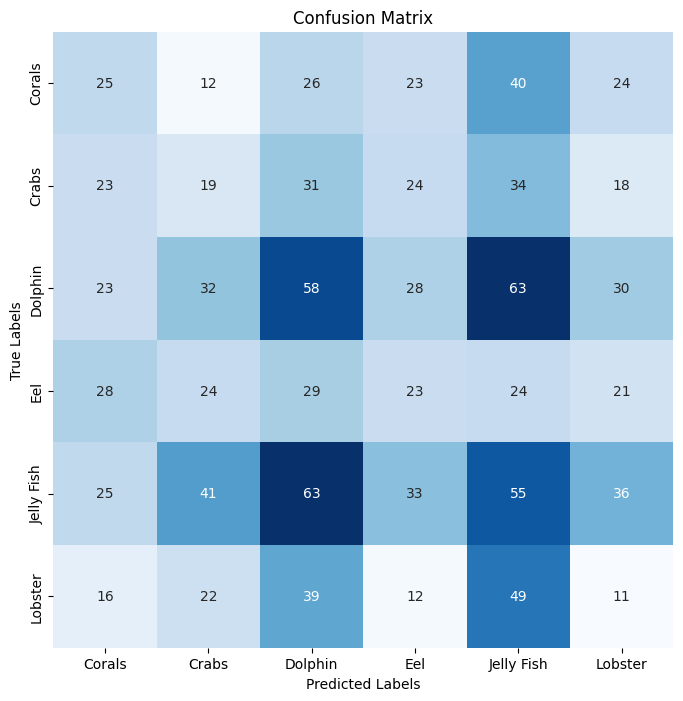

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate predictions for the validation dataset
predictions = model.predict(validation_generator, steps=len(validation_generator))
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels directly from the generator
true_labels = validation_generator.classes

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()